In [4]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
CUDA_LAUNCH_BLOCKING=1

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
task = 'B'

Extract dataframe from competition provided datasets

In [ ]:
def extract_df_from_file(task='A'):
    
    file_name = '../Datasets/twitter-task-A.txt' if task=='A' else '../Datasets/twitter-task-B.txt'
    file = open(file_name, 'r')
    Lines = file.readlines()

    all_elements = []
    
    count = 0
    for line in Lines:
        count += 1
        elements = line.split("\t")
        if(task=='A'):
          tweet, sentiment = elements[2], elements[1]
          all_elements.append([tweet, sentiment])
        else:
          tweet, topic, sentiment = elements[3], elements[1], elements[2]
          tweet+=topic
          all_elements.append([tweet, sentiment])
        
    return pd.DataFrame(all_elements, columns=['tweet', 'sentiment'])

In [ ]:
def sample_equal_distribution(df, task='A'):

  dfpos = df[df['sentiment']=='positive']
  dfneg = df[df['sentiment']=='negative']
  if task=='A':
    
    dfneu = df[df['sentiment']=='neutral']
    return pd.concat([dfpos.sample(n=2000), dfneg.sample(n=2000), dfneu.sample(n=2000)], ignore_index=True)
  else:
    return pd.concat([dfpos.sample(n=3000), dfneg.sample(n=3000)], ignore_index=True)

Extracts dataframe and splits data out into train/test/validation sets

In [ ]:
df = extract_df_from_file(task)
df = sample_equal_distribution(df, task)
print(df.shape)
print(df['sentiment'].value_counts())
le = preprocessing.LabelEncoder()
le.fit(df['sentiment'])
df['sentiment'] = le.transform(df['sentiment'])
train, test_val = train_test_split(df, test_size=0.3, stratify=df['sentiment'])
val, test = train_test_split(test_val, test_size=0.5, stratify=test_val['sentiment'])
print(train.shape)
print(test.shape)

(6000, 2)
positive    3000
negative    3000
Name: sentiment, dtype: int64
(4200, 2)
(900, 2)


Pre Processing of tweets in a bag of words model

In [ ]:
import re

def preprocess_text_bert(tweet):

  tweet = re.sub(r'(@.*?)[\s]', ' ', tweet)
  tweet = re.sub(r'&amp;', '&', tweet)
  tweet = re.sub(r'\s+', ' ', tweet).strip()

  return tweet

Tweets are pre-processed and tokenized

In [ ]:
%%time
!pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

train['tweet'] = train['tweet'].apply(preprocess_text_bert)
val['tweet'] = val['tweet'].apply(preprocess_text_bert)
test['tweet'] = test['tweet'].apply(preprocess_text_bert)

max_tweet_len_train = train['tweet'].str.len().max()
max_tweet_len_val = val['tweet'].str.len().max()
max_tweet_len_test = test['tweet'].str.len().max()

def tokenize_data_for_bert_model(tweets):

  feature_vectors = []
  attention_masks = []

  for tweet in tweets:

    res = tokenizer.encode_plus(
        text=tweet,
        add_special_tokens=True,
        max_length=max(max_tweet_len_train, max_tweet_len_val, max_tweet_len_test),
        pad_to_max_length=True,
        return_attention_mask=True
    )

    feature_vectors.append(res.get('input_ids'))
    attention_masks.append(res.get('attention_mask'))
  
  return torch.tensor(feature_vectors), torch.tensor(attention_masks)

     |████████████████████████████████| 4.0 MB 14.7 MB/s 
     |████████████████████████████████| 895 kB 85.6 MB/s 
     |████████████████████████████████| 596 kB 78.0 MB/s 
     |████████████████████████████████| 77 kB 6.8 MB/s 
     |████████████████████████████████| 6.6 MB 82.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

CPU times: user 2.44 s, sys: 223 ms, total: 2.66 s
Wall time: 13.6 s


Data is tokenized using BERT Tokenizer library

In [ ]:
bert_train, bert_train_masks = tokenize_data_for_bert_model(train['tweet'].to_numpy())
bert_val, bert_val_masks = tokenize_data_for_bert_model(val['tweet'].to_numpy())
bert_test, bert_test_masks = tokenize_data_for_bert_model(test['tweet'].to_numpy())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Test/Train/Validation data is extracted and batched and mapped to tensors

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

bert_train_sentiment = torch.tensor(train['sentiment'].to_numpy())
bert_val_sentiment = torch.tensor(val['sentiment'].to_numpy())
bert_test_sentiment = torch.tensor(test['sentiment'].to_numpy())

train_data = TensorDataset(bert_train, bert_train_masks, bert_train_sentiment)
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=16)

val_data = TensorDataset(bert_val, bert_val_masks, bert_val_sentiment)
val_dataloader = DataLoader(val_data, sampler=RandomSampler(val_data), batch_size=16)

test_data = TensorDataset(bert_test, bert_test_masks, bert_test_sentiment)
test_dataloader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=16)

In [ ]:
import torch.nn as nn
from transformers import BertModel

# Creates model stateful data
class BertClassifier(nn.Module):

    def __init__(self):
        super(BertClassifier, self).__init__()

        input_vector_dim = 768
        hidden_layer_dim = 192
        output_layer_dim = 3 if task=='A' else 2
        
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.classifier = nn.Sequential(
            nn.Linear(input_vector_dim, hidden_layer_dim),
            nn.ReLU(),
            nn.Linear(hidden_layer_dim, output_layer_dim)
        )
        
    def forward(self, feature_vector, attention_mask):

        outputs = self.bert(input_ids=feature_vector,
                            attention_mask=attention_mask)
        
        last_hidden_state_cls = outputs[0][:, 0, :]

        return self.classifier(last_hidden_state_cls)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def create_model(epochs=5):

    bert_classifier = BertClassifier()

    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,
                      eps=1e-8 
                      )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, 
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
import random
import time
from sklearn.metrics import classification_report

loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train_model(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    df = pd.DataFrame(columns=['Epoch','Batch','Train Loss','Val Loss','Val Acc','Elapsed'])

    print("Start training...")
    for i in range(epochs):

        epoch_i_time = time.time()
        batch_i_time = time.time()

        # Reset variables
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        print("==============")
        print("===Training===")
        print("==============")
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*80)

        # Iteration per batch
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1

            input_ids, attention_mask, labels = tuple(t for t in batch)

            # Clear any existing gradients
            model.zero_grad()

            # Run forward pass
            logits = model(input_ids, attention_mask)

            # Calculate loss by applying loss function
            loss = loss_fn(logits, labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Run backward pass
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            # Store results every 10 batches
            if (step % 10 == 0 and step != 0) or (step == len(train_dataloader) - 1):

                time_elapsed = time.time() - batch_i_time

                val_loss, val_accuracy = evaluate(model, val_dataloader)

                print(f"{i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
                
                new_row = {'Epoch': i, 'Batch': step, 'Train Loss': batch_loss / batch_counts, 'Val Loss': val_loss, 'Val Acc': val_accuracy, 'Elapsed': time_elapsed}
                df = df.append(new_row, ignore_index=True)
                
                batch_loss, batch_counts = 0, 0
                batch_i_time = time.time()

        avg_train_loss = total_loss / len(train_dataloader)

        # Print evaluation on validation set
        if evaluation:

            val_loss, val_accuracy = evaluate(model, val_dataloader, with_classification=True)

            time_elapsed = time.time() - epoch_i_time
            print(f"{i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        print("\n")
    
    df.to_csv('./drive/MyDrive/Colab Notebooks/Task' + task + 'Results2.csv')

    print("Training complete")


# Evaluates the model against the validation dataset
def evaluate(model, val_dataloader, with_classification=False):

    model.eval()

    val_accuracy = []
    val_loss = []

    final_labels = []
    final_preds = []

    for batch in val_dataloader:

        input_ids, attention_mask, labels = tuple(t for t in batch)

        with torch.no_grad():
            logits = model(input_ids, attention_mask)

        loss = loss_fn(logits, labels)
        val_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()

        final_labels.append(labels)
        final_preds.append(preds)
        
        accuracy = (preds == labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Logs the classification report
    if with_classification:
      print(classification_report(labels, preds))

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
set_seed(42) 
bert_classifier, optimizer, scheduler = create_model(epochs=2)
train_model(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...
===Training===
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------------------------------
   1    |   10    |   0.643454   |  0.581090  |   70.83   |   56.06  
   1    |   20    |   0.440958   |  0.490165  |   76.97   |   46.88  
   1    |   30    |   0.503018   |  0.634481  |   71.16   |   47.02  
   1    |   40    |   0.553618   |  0.386874  |   84.43   |   46.58  
   1    |   50    |   0.466187   |  0.344977  |   86.95   |   47.45  
   1    |   60    |   0.328196   |  0.389003  |   83.77   |   46.79  
   1    |   70    |   0.364266   |  0.312429  |   87.17   |   47.00  
   1    |   80    |   0.317906   |  0.317971  |   87.28   |   46.64  
   1    |   90    |   0.332590   |  0.304573  |   87.28   |   46.49  
   1    |   100   |   0.333031   |  0.302796  |   87.17   |   46.63  
   1    |   110   |   0.257486   |  0.311677  |   86.95   |   46.69  
   1    |   120   |   0.407984   |  0.334558  

In [ ]:
val_loss, val_accuracy = evaluate(bert_classifier, test_dataloader, with_classification=True)
print('Test Results')
print('Validation Loss: ' + str(val_loss))
print('Validation Accuracy: ' + str(val_accuracy))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         3

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

Test Results
Validation Loss: 0.47989680685037583
Validation Accuracy: 86.95175438596492


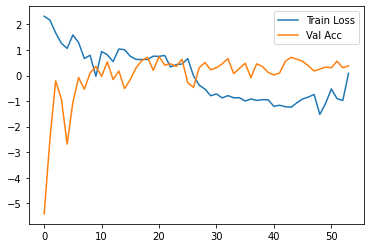

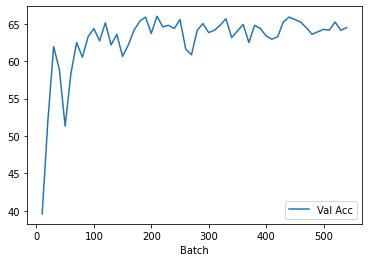

In [19]:
task_a_results = './TaskAResults2.csv'
df_task_a_results = pd.read_csv(task_a_results)
normalized_df_a_results=(df_task_a_results-df_task_a_results.mean())/df_task_a_results.std()
normalized_df_a_results[['Train Loss', 'Val Acc']].plot()
df_task_a_results[['Batch', 'Val Acc']].plot(x='Batch', y='Val Acc')

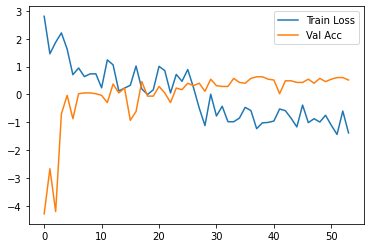

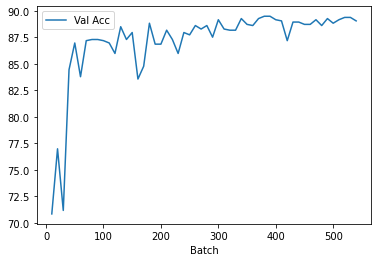

In [20]:
task_b_results = './TaskBResults2.csv'
df_task_b_results = pd.read_csv(task_b_results)
normalized_df_b_results=(df_task_b_results-df_task_b_results.mean())/df_task_b_results.std()
normalized_df_b_results[['Train Loss', 'Val Acc']].plot()
df_task_b_results[['Batch', 'Val Acc']].plot(x='Batch', y='Val Acc')